In [1]:
%cd ..
%pwd

/home/quasar/GitHub/TradeForecast


/home/quasar/GitHub/TradeForecast/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/home/quasar/GitHub/TradeForecast'

In [2]:
from tradeforecast.augmentation import RNNDataset
from tradeforecast.viz import plot_rnn_forecasts
from tradeforecast.forecast.base import LitBase
from torch.utils.data import DataLoader
from lightning import Trainer
from torch import Tensor
from torch import optim
import torch.nn.functional as F

def predict(model: LitBase, data_loader: DataLoader, dataset: RNNDataset):
    y: Tensor; y_pred: Tensor
    y, y_pred = model.predict(data_loader)
    y = dataset.inverse_transform(y.numpy())
    y_pred = dataset.inverse_transform(y_pred.numpy())
    plot_rnn_forecasts(y, y_pred)
    return

In [3]:
from tradeforecast.augmentation import DataEntryPoint, Indicators, FeatureEngg

data_entry = DataEntryPoint(csv_fpath='AAPL_1d_max_(2010-01-01-2024-12-06).csv')

indicators = Indicators(data_entry)
indicators.add_moving_average(n=9).add_moving_average(n=16).add_macd_sl().add_rsi().add_atr()

features = FeatureEngg(data_entry)
features.add_quarters().add_weeks().add_hours().add_minutes()

lf = data_entry.data.drop_nulls()
lf.collect().head()

Datetime,Close,High,Low,Open,Volume,SMA_close_9,SMA_close_16,MACD_close_12-26,MACD-SL_close_9,RSI_close_14,ATR_close_14,Quarter_sin,Quarter_cos,Week_sin,Week_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos
"datetime[μs, EST]",f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-02-21 19:00:00 EST,7.157857,7.232143,7.113929,7.226429,390563600,7.148135,7.064375,-0.020182,-0.043646,50.213892,0.152137,1.0,0.0,0.737833,0.674983,-0.965926,0.258819,0.0,1.0
2010-02-22 19:00:00 EST,7.037857,7.190357,6.989643,7.142857,575094800,7.151587,7.075536,-0.027162,-0.039953,40.503417,0.158657,1.0,0.0,0.812487,0.582979,-0.965926,0.258819,0.0,1.0
2010-02-23 19:00:00 EST,7.166429,7.194286,7.065714,7.079643,460566400,7.173572,7.088772,-0.02264,-0.036165,51.982977,0.158358,1.0,0.0,0.812487,0.582979,-0.965926,0.258819,0.0,1.0
2010-02-24 19:00:00 EST,7.214286,7.245,7.031786,7.049286,665126000,7.186786,7.102478,-0.015228,-0.031669,55.657482,0.165709,1.0,0.0,0.812487,0.582979,-0.965926,0.258819,0.0,1.0
2010-02-25 19:00:00 EST,7.307857,7.3275,7.214286,7.227857,507460800,7.203611,7.114509,-0.002156,-0.025423,62.185845,0.158679,1.0,0.0,0.812487,0.582979,-0.965926,0.258819,0.0,1.0


In [4]:
from tradeforecast.augmentation import train_val_test_split

dataset_kwargs = {'lf': lf,
                 'non_temporal': data_entry.non_temporal,
                 'temporal': data_entry.temporal,
                 'target': 'Close',
                 'look_back_len': 60,
                 'forecast_len': 5}

rnn_dataset = RNNDataset(**dataset_kwargs)

train_dataset, val_dataset, test_dataset = train_val_test_split(rnn_dataset, val_size=0.1, test_size=0.1)

batch_size = 128
num_workers = 10

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=num_workers)

## Train LSTM model

In [5]:
from tradeforecast.forecast import LSTM
from tradeforecast.forecast.utils import OverrideEpochStepCallback

lstm_kwargs = {'input_size': len(rnn_dataset.features),
              'hidden_size': 32,
              'n_LSTM': 2,
              'bidirectional': False,
              'fc_out_size':[],
              'output_size': rnn_dataset.forecast_len,
              'dropout': 0,
              'criterion': F.mse_loss,
              'lr': 0.005,
              'optimizer': optim.SGD}

lstm_model = LSTM(**lstm_kwargs)

lstm_trainer = Trainer(fast_dev_run=False, max_epochs=1500, log_every_n_steps=10, check_val_every_n_epoch=100)

lstm_trainer.fit(lstm_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | lstm      | LSTM       | 15.2 K | train
1 | fc_linear | Sequential | 165    | train
-------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Epoch 1499: 100%|██████████| 23/23 [00:00<00:00, 38.57it/s, v_num=15, train_loss=0.00842, val_loss=0.0381] 

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 23/23 [00:00<00:00, 38.48it/s, v_num=15, train_loss=0.00842, val_loss=0.0381]


In [6]:
lstm_trainer.test(lstm_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 185.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.12538118660449982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.12538118660449982}]

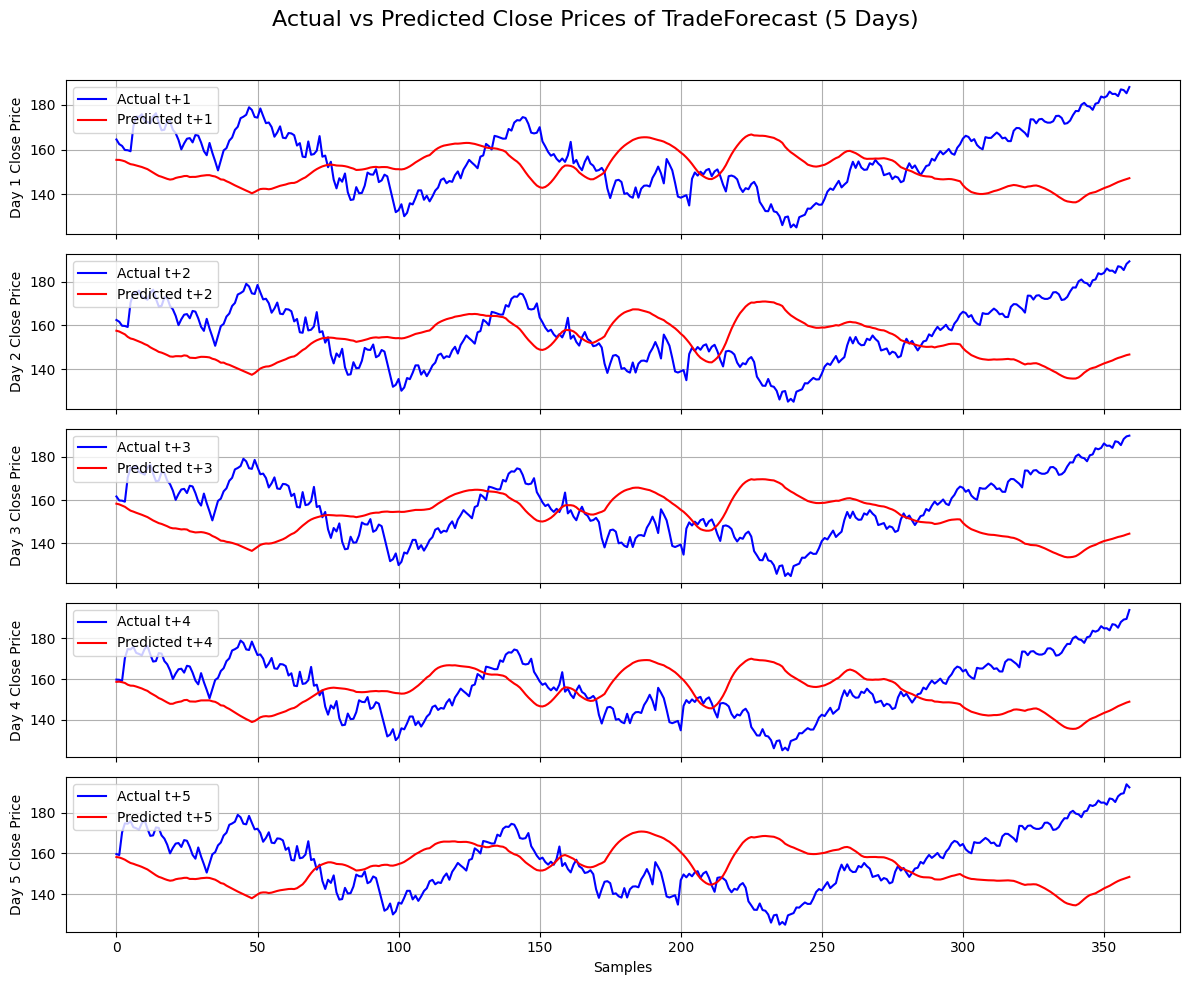

In [7]:
predict(lstm_model, val_loader, rnn_dataset)

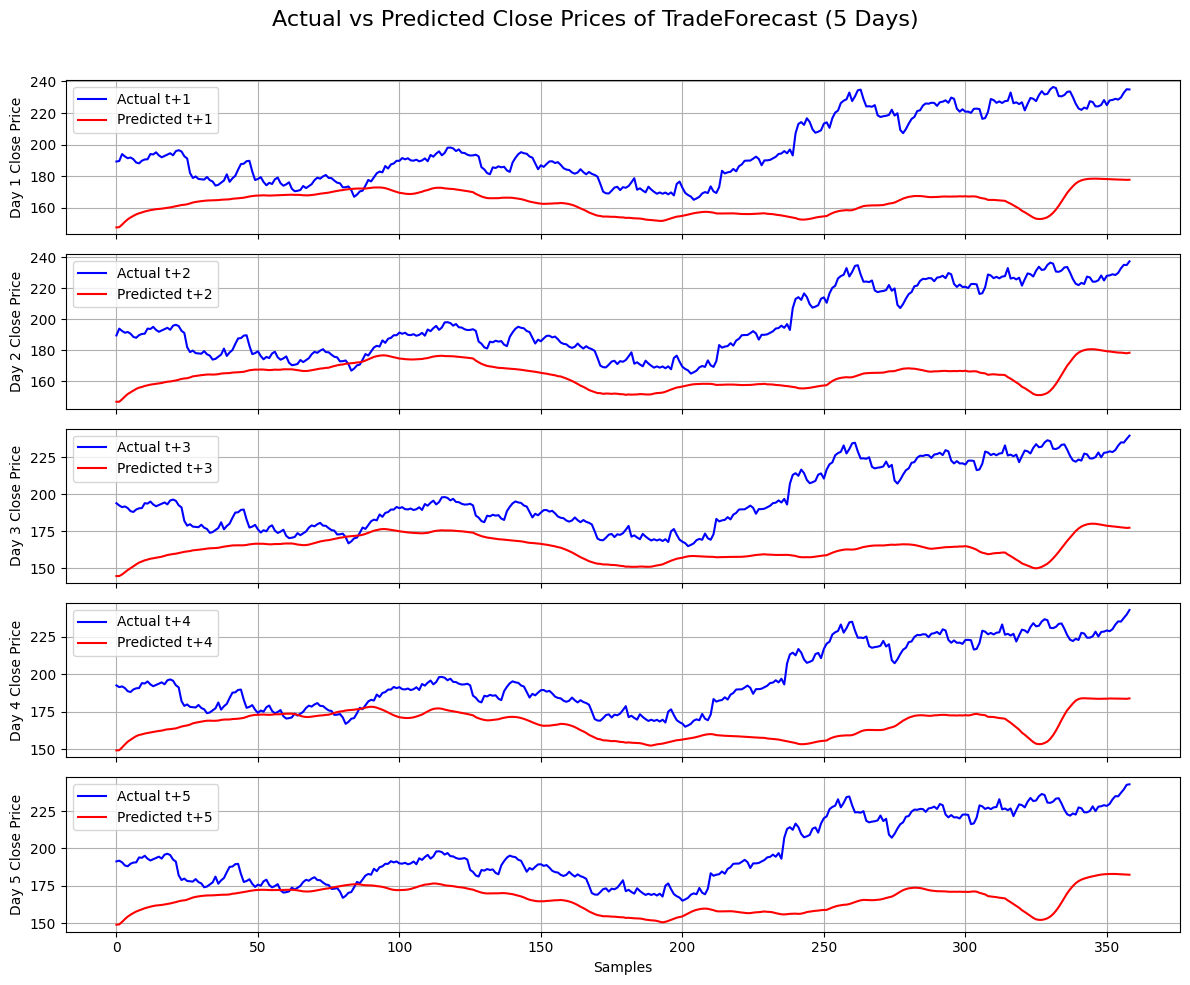

In [8]:
predict(lstm_model, test_loader, rnn_dataset)

In [9]:
model_fname = lstm_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_LSTM_15397_5.pth'

## Train TF model

In [10]:
from tradeforecast.forecast import TFModel

tf_kwargs = {'input_size': len(rnn_dataset.features),
            'conv_out_size': len(rnn_dataset.features)*2,
            'kernel_size': 3,
            'hidden_size': 32,
            'n_LSTM': 2,
            'bidirectional': False,
            'fc_out_size':[],
            'output_size': rnn_dataset.forecast_len,
            'dropout': 0,
            'criterion': F.mse_loss,
            'lr': 0.005,
            'optimizer': optim.SGD}

tf_model = TFModel(**tf_kwargs)

tf_trainer = Trainer(fast_dev_run=False, max_epochs=1500, log_every_n_steps=10, check_val_every_n_epoch=100)

tf_trainer.fit(tf_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params | Mode 
--------------------------------------------------
0 | conv1d    | Conv1d      | 2.2 K  | train
1 | bnorm     | BatchNorm1d | 76     | train
2 | avg_pool  | AvgPool1d   | 0      | train
3 | lstm      | LSTM        | 17.7 K | train
4 | fc_linear | Sequential  | 165    | train
--------------------------------------------------
20.1 K    Trainable params
0         Non-trainable params
20.1 K    Total params
0.080     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 1499: 100%|██████████| 23/23 [00:00<00:00, 36.75it/s, v_num=16, train_loss=0.00152, val_loss=0.276] 

`Trainer.fit` stopped: `max_epochs=1500` reached.


Epoch 1499: 100%|██████████| 23/23 [00:00<00:00, 36.67it/s, v_num=16, train_loss=0.00152, val_loss=0.276]


In [11]:
tf_trainer.test(tf_model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 199.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6704707145690918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6704707145690918}]

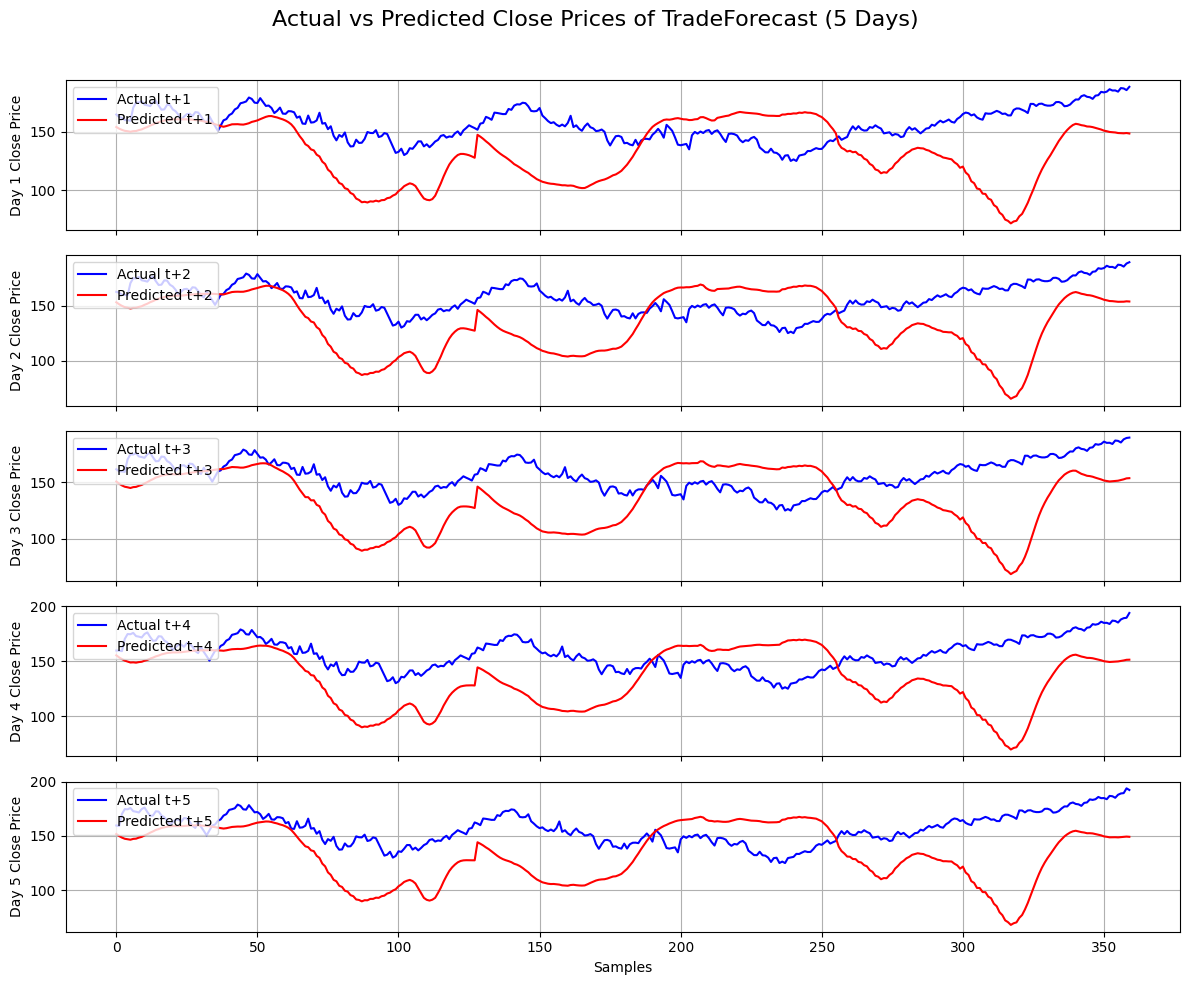

In [12]:
predict(tf_model, val_loader, rnn_dataset)

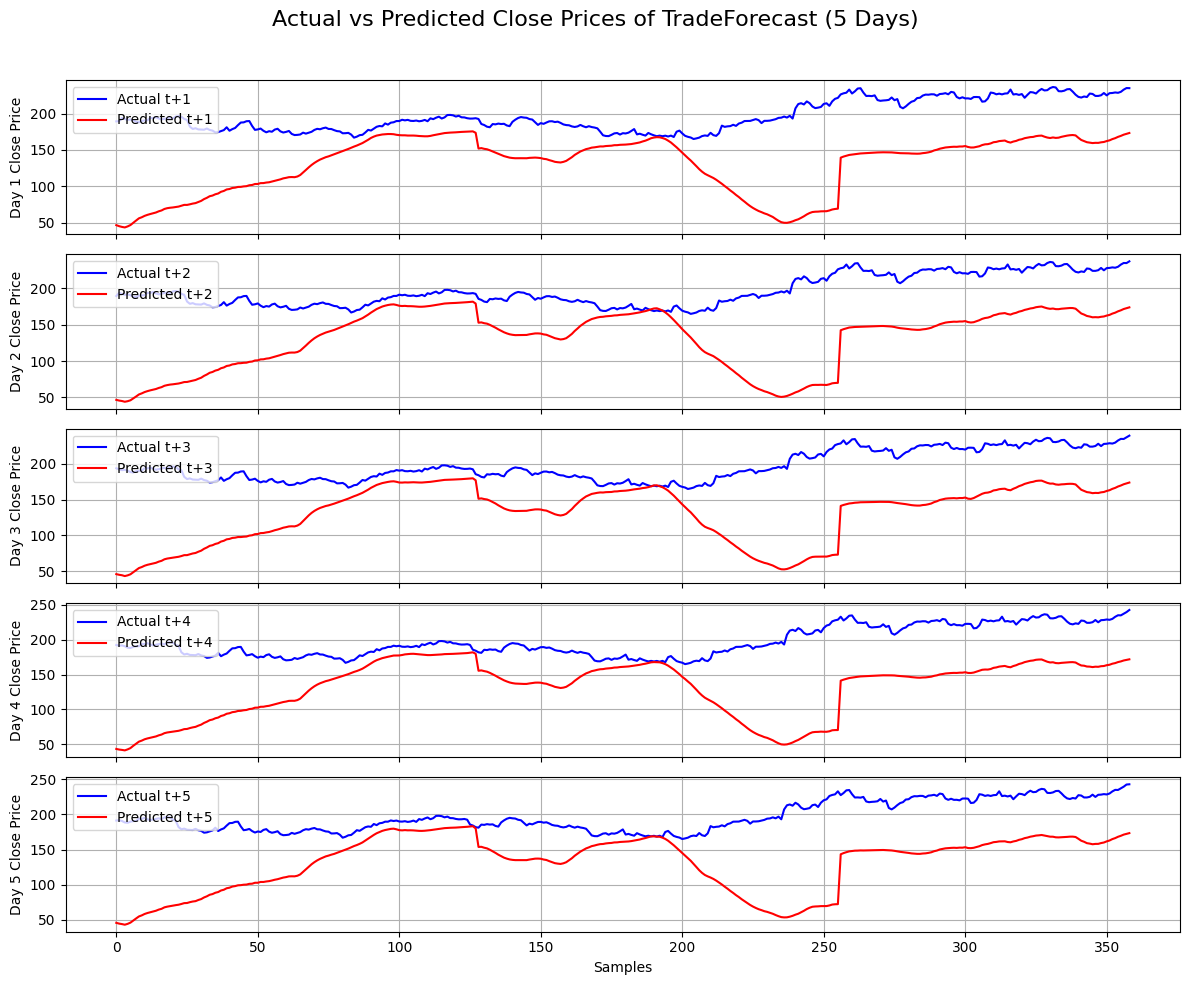

In [13]:
predict(tf_model, test_loader, rnn_dataset)

In [14]:
model_fname = tf_model.save_model_state(ticker_interval='AAPL_1d')
model_fname

'AAPL_1d_TFModel_20109_5.pth'